In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

from propensity_score import *

In [2]:
df = pd.read_csv("../../data/promotion_campaign.csv")
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


### Data Description
- Context
    - Marketing Promotion Campaign
    - with a total of 6,400 customers data.

- Content
    - This dataset show customer's brief information,
    - historical use of discount or BOGO(Buy One Get One) promotion,
    - offer has been made, and the conversion result(buy or not).
    - The conversion average value = $25

- Columns
    - recency : months since last purchase
    - history : $value of the historical purchases
    - used_discount : indicates if the customer used a discount before
    - used_bogo : indicates if the customer used a buy one get one before
    - zip_code : class of the zip code as Suburban/Urban/Rural
    - is_referral : indicates if the customer was acquired from referral channel
    - channel : channels that the customer using, Phone/Web/Multichanne l
    - offer : the offers sent to the customers, Discount/Buy One Get One/No Offer
    - conversion : customer conversion(buy or not)

- Questions
    - bogo counpon의 사용은 conversion에 유의미한 영향을 미치는가?
    - bogo coupon 과 discount 중 어떤 offer 가 conversion에 더 유의미한 영향을 미치는가?

In [3]:
# 각 offer 별 차이
df['offer'].value_counts()

offer
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64

In [4]:
df.groupby('offer').agg({'conversion': 'mean'})

,conversion
offer,
Buy One Get One,0.151400
Discount,0.182757
No Offer,0.106167


In [5]:
# 특정한 channel 혹은 referral, zip_code 에 따라 offer 가 다르게 제공되었을까?
print(df.groupby(['is_referral'])['offer'].value_counts())
print(df.groupby(['channel'])['offer'].value_counts())
print(df.groupby(['zip_code'])['offer'].value_counts())


is_referral  offer          
0            Buy One Get One    10624
             Discount           10621
             No Offer           10611
1            Buy One Get One    10763
             No Offer           10695
             Discount           10686
Name: count, dtype: int64
channel       offer          
Multichannel  No Offer           2606
              Buy One Get One    2579
              Discount           2577
Phone         Buy One Get One    9454
              No Offer           9327
              Discount           9240
Web           Discount           9490
              No Offer           9373
              Buy One Get One    9354
Name: count, dtype: int64
zip_code   offer          
Rural      Discount           3243
           Buy One Get One    3181
           No Offer           3139
Surburban  Buy One Get One    9650
           No Offer           9625
           Discount           9501
Urban      Discount           8563
           Buy One Get One    8556
           N

In [6]:
# 과거의 offer 경험 여부, 특정한 channel 혹은 referral, zip_code 에 따라 offer 가 다르게 제공되었을까?(chi-square test) >> No
print(stats.chi2_contingency(df.groupby(['used_discount', 'offer']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['used_bogo', 'offer']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_referral', 'offer']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['channel', 'offer']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['zip_code', 'offer']).size().unstack()))

Chi2ContingencyResult(statistic=0.7959944587977451, pvalue=0.6716638885721589, dof=2, expected_freq=array([[ 9602.09465625,  9566.17715625,  9565.7281875 ],
       [11784.90534375, 11740.82284375, 11740.2718125 ]]))
Chi2ContingencyResult(statistic=0.6325216388374403, pvalue=0.7288693221012423, dof=2, expected_freq=array([[ 9630.16509375,  9594.14259375,  9593.6923125 ],
       [11756.83490625, 11712.85740625, 11712.3076875 ]]))
Chi2ContingencyResult(statistic=0.13686799114871678, pvalue=0.9338550966386445, dof=2, expected_freq=array([[10645.37925, 10605.55925, 10605.0615 ],
       [10741.62075, 10701.44075, 10700.9385 ]]))
Chi2ContingencyResult(statistic=3.6324016175409097, pvalue=0.45803390781197906, dof=4, expected_freq=array([[2593.84209375, 2584.13959375, 2584.0183125 ],
       [9363.83010937, 9328.80385938, 9328.36603125],
       [9429.32779688, 9394.05654687, 9393.61565625]]))
Chi2ContingencyResult(statistic=2.8719422089251405, pvalue=0.5794791381657298, dof=4, expected_freq=arra

In [7]:
# recency 나 history 에 따라 offer 제공에 차이가 있는가? >> 없음
df['is_offer'] = df['offer'].apply(lambda x: 1 if x != 'No Offer' else 0)
print(stats.ttest_ind(df[df['is_offer'] == 1]['recency'], df[df['is_offer'] == 0]['recency']))
df.groupby(['is_offer'])['recency'].describe().T

Ttest_indResult(statistic=0.7153145266904226, pvalue=0.47441732378425583)


is_offer,0,1
count,21306.000000,42694.000000
mean,5.749695,5.770741
std,3.497517,3.512628
min,1.000000,1.000000
25%,2.000000,2.000000
50%,5.000000,6.000000
75%,9.000000,9.000000
max,12.000000,12.000000


In [8]:
print(stats.ttest_ind(df[df['is_offer'] == 1]['history'], df[df['is_offer'] == 0]['history']))
df.groupby(['is_offer'])['history'].describe().T

Ttest_indResult(statistic=0.8392939858135674, pvalue=0.40130749232369134)


is_offer,0,1
count,21306.000000,42694.000000
mean,240.882653,242.686002
std,252.739362,257.848830
min,29.990000,29.990000
25%,65.300000,64.350000
50%,156.655000,158.870000
75%,325.167500,325.780000
max,3345.930000,3215.970000


In [9]:
print(df.groupby('conversion').agg({'recency': 'mean', 'history': 'mean'}))
# conversion 에 따른 recency 와 history 의 평균 차이가 유의미 한가? (T-test) >> yes
print(stats.ttest_ind(df[df['conversion'] == 1]['recency'], df[df['conversion'] == 0]['recency']))
print(stats.ttest_ind(df[df['conversion'] == 1]['history'], df[df['conversion'] == 0]['history']))


             recency     history
conversion                      
0           5.872505  235.163403
1           5.131467  282.323739
Ttest_indResult(statistic=-18.96709150895096, pvalue=5.294913346838018e-80)
Ttest_indResult(statistic=16.517478781985094, pvalue=3.677981177850362e-61)


In [10]:
# offer 제공 여부와 다른 변수들간 연관성이 있는가?
print(stats.chi2_contingency(df.groupby(['is_offer', 'used_discount']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_offer', 'used_bogo']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_offer', 'is_referral']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_offer', 'channel']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_offer', 'zip_code']).size().unstack()))

Chi2ContingencyResult(statistic=0.6077606741026186, pvalue=0.43563220385181545, dof=1, expected_freq=array([[ 9565.7281875, 11740.2718125],
       [19168.2718125, 23525.7281875]]))
Chi2ContingencyResult(statistic=0.5454908235404397, pvalue=0.46016601712300187, dof=1, expected_freq=array([[ 9593.6923125, 11712.3076875],
       [19224.3076875, 23469.6923125]]))
Chi2ContingencyResult(statistic=0.008324118558984524, pvalue=0.9273045876149367, dof=1, expected_freq=array([[10605.0615, 10700.9385],
       [21250.9385, 21443.0615]]))
Chi2ContingencyResult(statistic=0.3484331548364195, pvalue=0.8401149280317741, dof=2, expected_freq=array([[ 2584.0183125 ,  9328.36603125,  9393.61565625],
       [ 5177.9816875 , 18692.63396875, 18823.38434375]]))
Chi2ContingencyResult(statistic=1.2569459007234598, pvalue=0.5334057164104189, dof=2, expected_freq=array([[ 3183.58246875,  9579.71025   ,  8542.70728125],
       [ 6379.41753125, 19196.28975   , 17118.29271875]]))


In [11]:
# conversion 이 된 고객일수록 최근까지 구매 경험이 있고 더 많이 금액을 지불함
df.groupby('conversion')[['history','recency']].describe().T

conversion                0            1
history count  54606.000000  9394.000000
        mean     235.163403   282.323739
        std      251.053967   280.674183
        min       29.990000    29.990000
        25%       62.670000    80.565000
        50%      151.835000   202.460000
        75%      315.352500   384.632500
        max     3345.930000  3215.970000
recency count  54606.000000  9394.000000
        mean       5.872505     5.131467
        std        3.500573     3.481646
        min        1.000000     1.000000
        25%        3.000000     2.000000
        50%        6.000000     4.000000
        75%        9.000000     8.000000
        max       12.000000    12.000000

In [12]:
# 과거에 쿠폰이나 할인 경험에, referral 유입 여부와 conversion 간 연관성이 있을까? >> yes
print(stats.chi2_contingency(df.groupby(['used_discount', 'conversion']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['used_bogo', 'conversion']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_referral', 'conversion']).size().unstack()))

Chi2ContingencyResult(statistic=2.8452499347404023, pvalue=0.09164434163363895, dof=1, expected_freq=array([[24516.3875625,  4217.6124375],
       [30089.6124375,  5176.3875625]]))
Chi2ContingencyResult(statistic=172.7557392727885, pvalue=1.8506024687525893e-39, dof=1, expected_freq=array([[24588.0579375,  4229.9420625],
       [30017.9420625,  5164.0579375]]))
Chi2ContingencyResult(statistic=349.3264372550735, pvalue=5.940429321710465e-78, dof=1, expected_freq=array([[27180.1365,  4675.8635],
       [27425.8635,  4718.1365]]))


In [13]:
# 과거에 쿠폰 사용 경험이 zip_code, channel, is_referral 과 연관성이 있을까? >> zip_code 는 연관성이 없으나 사용 channel과 referral 유입 여부와는 연관성이 있음
print(stats.chi2_contingency(df.groupby(['zip_code', 'used_discount']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['channel', 'used_discount']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_referral', 'used_discount']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['zip_code', 'used_bogo']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['channel', 'used_bogo']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_referral', 'used_bogo']).size().unstack()))

Chi2ContingencyResult(statistic=0.8648039811531674, pvalue=0.6489484530814188, dof=2, expected_freq=array([[ 4293.48815625,  5269.51184375],
       [12919.52475   , 15856.47525   ],
       [11520.98709375, 14140.01290625]]))
Chi2ContingencyResult(statistic=238.20288589517784, pvalue=1.8832177597474356e-52, dof=2, expected_freq=array([[ 3484.8954375 ,  4277.1045625 ],
       [12580.55334375, 15440.44665625],
       [12668.55121875, 15548.44878125]]))
Chi2ContingencyResult(statistic=27.87204954876849, pvalue=1.2960858187126486e-07, dof=1, expected_freq=array([[14302.3485, 17553.6515],
       [14431.6515, 17712.3485]]))
Chi2ContingencyResult(statistic=0.21821951854909416, pvalue=0.8966319984194486, dof=2, expected_freq=array([[ 4306.03959375,  5256.96040625],
       [12957.29325   , 15818.70675   ],
       [11554.66715625, 14106.33284375]]))
Chi2ContingencyResult(statistic=197.9929561655849, pvalue=1.0147892099005767e-43, dof=2, expected_freq=array([[ 3495.0830625 ,  4266.9169375 ],
     

In [14]:
# multichannel 을 사용하는 고객인 경우 과거에 할인 offer 를 받을 가능성이 높음
print(df.groupby(['channel'])['used_discount'].value_counts(normalize=True))
print(df.groupby(['channel'])['used_bogo'].value_counts(normalize=True))


channel       used_discount
Multichannel  1                0.632698
              0                0.367302
Phone         1                0.539203
              0                0.460797
Web           1                0.540313
              0                0.459687
Name: proportion, dtype: float64
channel       used_bogo
Multichannel  1            0.624195
              0            0.375805
Phone         1            0.538953
              0            0.461047
Web           1            0.539923
              0            0.460077
Name: proportion, dtype: float64


In [15]:
# referral 을 통해 유입된 고객일 경우 과거에 할인 offer 를 받을 가능성이 높음
print(df.groupby(['is_referral'])['used_discount'].value_counts(normalize=True))
print(df.groupby(['is_referral'])['used_bogo'].value_counts(normalize=True))


is_referral  used_discount
0            1                0.540589
             0                0.459411
1            1                0.561380
             0                0.438620
Name: proportion, dtype: float64
is_referral  used_bogo
0            1            0.539051
             0            0.460949
1            1            0.560291
             0            0.439709
Name: proportion, dtype: float64


In [16]:
# channel 과 is_referral 에 따라 conversion 에 차이가 있을까? >> 연관성이 있음
print(stats.chi2_contingency(df.groupby(['channel', 'conversion']).size().unstack()))
print(stats.chi2_contingency(df.groupby(['is_referral', 'conversion']).size().unstack()))

Chi2ContingencyResult(statistic=160.69711674409655, pvalue=1.2736921440078863e-35, dof=2, expected_freq=array([[ 6622.6839375 ,  1139.3160625 ],
       [23908.04259375,  4112.95740625],
       [24075.27346875,  4141.72653125]]))
Chi2ContingencyResult(statistic=349.3264372550735, pvalue=5.940429321710465e-78, dof=1, expected_freq=array([[27180.1365,  4675.8635],
       [27425.8635,  4718.1365]]))


In [17]:
print(stats.ttest_ind(df[df['used_discount'] == 1]['recency'], df[df['used_discount'] == 0]['recency']))
print(stats.ttest_ind(df[df['used_discount'] == 1]['history'], df[df['used_discount'] == 0]['history']))
print(stats.ttest_ind(df[df['used_bogo'] == 1]['recency'], df[df['used_bogo'] == 0]['recency']))
print(stats.ttest_ind(df[df['used_bogo'] == 1]['history'], df[df['used_bogo'] == 0]['history']))


Ttest_indResult(statistic=-7.931236223550095, pvalue=2.204602520336111e-15)
Ttest_indResult(statistic=28.687516184599673, pvalue=7.57390265343429e-180)
Ttest_indResult(statistic=-6.735824632699262, pvalue=1.6437592745164404e-11)
Ttest_indResult(statistic=29.205421588402057, pvalue=2.7866045770669983e-186)


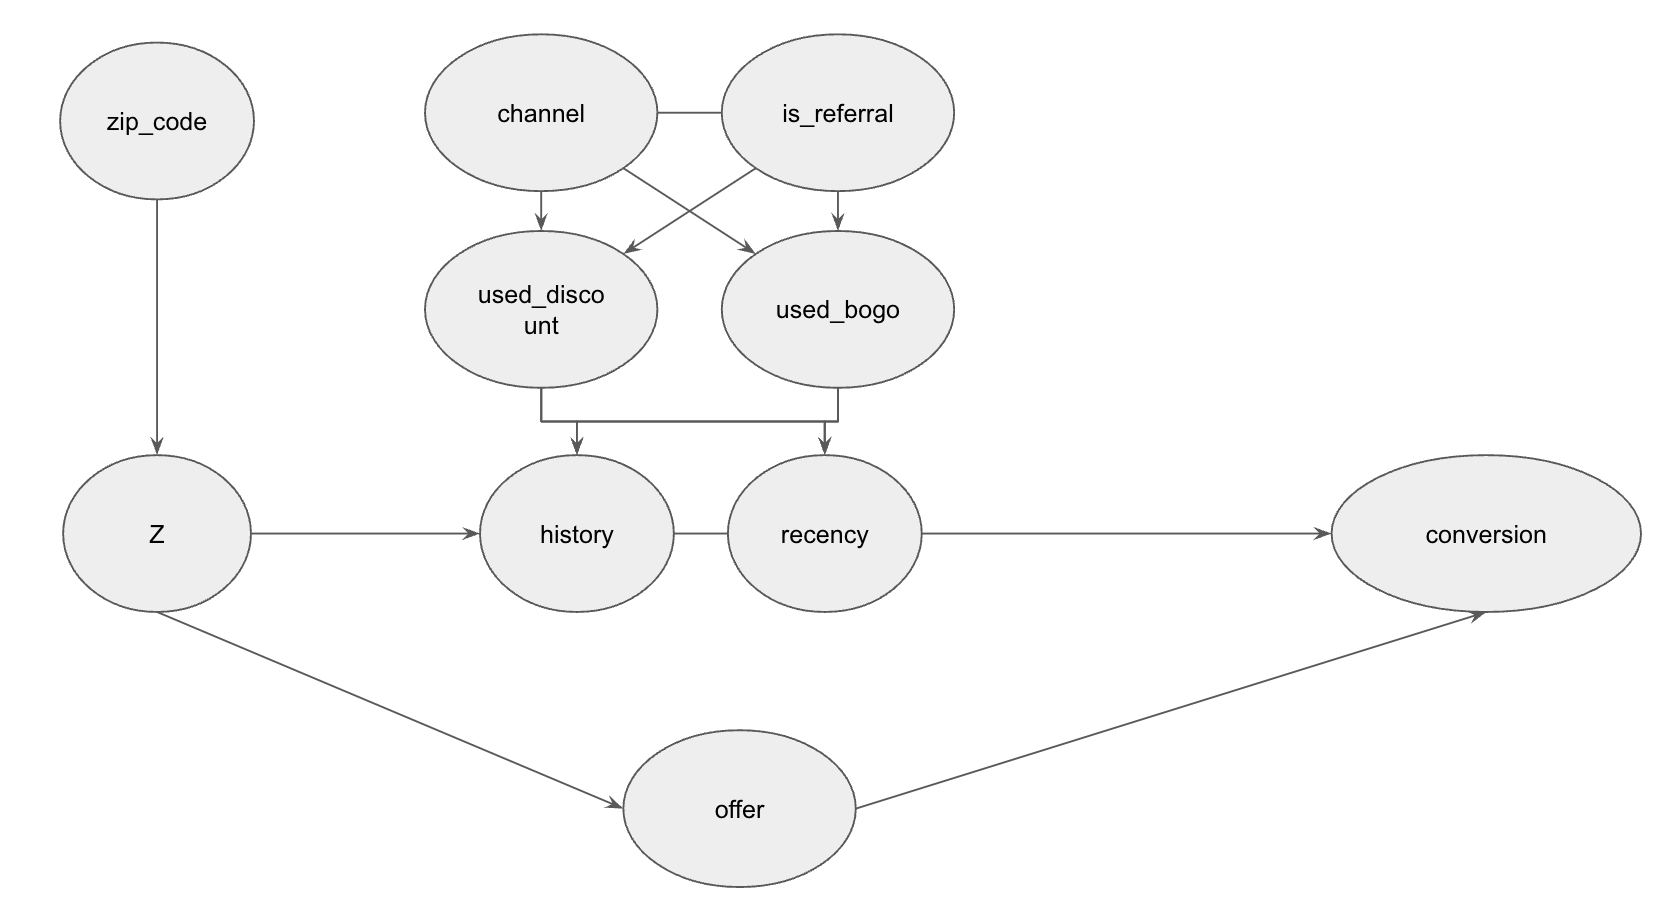

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
 9   is_offer       64000 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 4.9+ MB


In [19]:
categorical_cols = ['used_discount', 'used_bogo', 'is_referral', 'channel', 'zip_code']
for col in categorical_cols:
    df[col] = df[col].astype('object')

In [20]:
df.to_csv('../../data/promotion_campaign_prep.csv', index=False)

----

In [ ]:

scaler = StandardScaler()
df[['sc_history','sc_recency']] = scaler.fit_transform(df[['history','recency']]) 

In [140]:
formula = "conversion ~ is_offer"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     423.4
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           8.80e-94
Time:                        10:21:05   Log-Likelihood:                -24119.
No. Observations:               64000   AIC:                         4.824e+04
Df Residuals:                   63998   BIC:                         4.826e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1062      0.002     43.934      0.0

In [139]:
formula = "conversion ~ is_offer + sc_history + sc_recency + is_referral + used_discount + used_bogo + C(channel) + C(zip_code)"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     219.9
Date:                Fri, 17 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:18:15   Log-Likelihood:                -23249.
No. Observations:               64000   AIC:                         4.652e+04
Df Residuals:                   63989   BIC:                         4.662e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [105]:
formula = "conversion ~ is_offer + sc_history + sc_recency + is_referral + used_discount + used_bogo + C(channel) + C(zip_code)"
model = smf.logit(formula=formula, data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.400504
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:                64000
Model:                          Logit   Df Residuals:                    63989
Method:                           MLE   Df Model:                           10
Date:                Thu, 16 Jan 2025   Pseudo R-squ.:                 0.03975
Time:                        15:52:28   Log-Likelihood:                -25632.
converged:                       True   LL-Null:                       -26693.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3662      0.062    -38.024      0.000      -2.488

In [155]:
X_base = df.copy()
X_base = pd.concat(
[X_base[['is_referral','used_discount','used_bogo']],
pd.get_dummies(X_base['channel'],drop_first=True),
pd.get_dummies(X_base['zip_code'],drop_first=True),
X_base[['sc_history','sc_recency']]], axis=1
)

In [156]:
X_base.head()

,is_referral,used_discount,used_bogo,Phone,Web,Surburban,Urban,sc_history,sc_recency
0,0,1,0,True,False,True,False,-0.389003,1.207751
1,1,1,1,False,True,False,False,0.339614,0.067359
2,1,0,1,False,True,True,False,-0.239836,0.352457
3,1,1,0,False,True,False,False,1.693278,0.922653
4,0,1,0,False,True,False,True,-0.768068,-1.073034


In [160]:
# 로지스틱 회귀 결과 계수
intercept = -2.3665  # Intercept
offer_coeff = 0.5366
other_coefficients = np.array([-0.5569, 0.5715, 0.7262, -0.0999, 0.1660, -0.3574, -0.3723, 0.1211, -0.1865])

# 예: 기준 상태(no_offer)에서의 공변량 X 값 (예시값)
# X_base = X_base.values  # 예: Phone=1, Web=0

# 1. 기준 상태(no_offer)의 확률 계산
log_odds_no_offer = intercept + np.dot(X_base.astype(float).values, other_coefficients)
print(log_odds_no_offer)
P_no_offer = np.exp(log_odds_no_offer) / (1 + np.exp(log_odds_no_offer))

# 3. Discount 쿠폰 처치 상태의 확률 계산
log_odds_discount = log_odds_no_offer + offer_coeff
P_offer = np.exp(log_odds_discount) / (1 + np.exp(log_odds_discount))

# 4. ATE 계산
ATE_offer = np.mean(P_offer - P_no_offer)
print(ATE_offer)

[-2.52465389 -1.43113519 -2.48337741 ... -2.93693228 -2.30904965
 -1.469327  ]
0.060733969295575056


In [161]:
formula = "conversion ~ is_BOGO + is_Discount"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     254.2
Date:                Fri, 17 Jan 2025   Prob (F-statistic):          1.07e-110
Time:                        10:57:22   Log-Likelihood:                -24077.
No. Observations:               64000   AIC:                         4.816e+04
Df Residuals:                   63997   BIC:                         4.819e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1062      0.002     43.963      

In [162]:
formula = "conversion ~ is_BOGO + is_Discount + sc_history + sc_recency + is_referral + used_discount + used_bogo + C(channel) + C(zip_code)"
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     207.7
Date:                Fri, 17 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:57:52   Log-Likelihood:                -23208.
No. Observations:               64000   AIC:                         4.644e+04
Df Residuals:                   63988   BIC:                         4.655e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

* OLS 결과와 로지스틱 회귀 결과가 유사한 경우
    * 결과 변수의 범위가 극단적이지 않을 경우
        * $P(Y=1|X)$의 값이 0 ~ 1 사이에 균등하게 분포한다면, OLS 와 로지스틱 함수 간 차이가 없을 수 있다.
        * 공변량의 선형 관계가 강한 경우
        * 데이터의 크기가 충분히 큰 경우
* 결과 변수가 이진 변수일 때 OLS 를 통한 ATE를 산출?
    * OLS 는 결과 변수의 예측값을 무한대의 범위에서 반환할 수 있다.
    * P(Y=1) 가 [0,1] 이므로 확률 해석이 어려움
    * 이진 결과 변수에서 분산을 과소 또는 과대 추정할 수 있다.
    * 공변량 간의 비선형 관계가 있을 때 문제
* 즉, 일반화된 분석과 해석을 위해서는 로지스틱 회귀를 통해 로그 오즈비를 확률 차이로 변환하는 과정을 거쳐 ATE를 산출하는게 더 적합한 방법